# Let's make a sounding from the GFS 0.25 degree ouput!
* GFS 0.25 degree output is roughly 20 GB per run.
* We only need data along a vertical line at one latitude / longitude at one point in time to make a sounding (let's say the time we are interested in is the time closest to now).
* Goals:
 1. Use the Unidata THREDDS Data Server and siphon to request only the data we need for a sounding.
 2. Use metpy to create the sounding.

In [1]:
import datetime as dt
import dateutil.parser
import numpy as np
import matplotlib.pyplot as plt

from metpy.calc import dewpoint_rh, lcl, dry_lapse, parcel_profile
from metpy.plots import SkewT
from metpy.units import units, concatenate

from siphon.catalog import get_latest_access_url
from siphon.ncss import NCSS

In [2]:
# just for fun, let's time this
start = dt.datetime.now()

In [3]:
# where would we like to get the sounding?
lat = 40
lon = -105

# get the latest run of the GFS 0.25 degree model, and request the data 
# needed to make a sounding for a given lat/lon point

latest_gfs_quarter_deg = get_latest_access_url("http://thredds-jumbo.unidata.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml", "NetcdfSubset")
ncss = NCSS(latest_gfs_quarter_deg)

query = ncss.query()
query.accept('netcdf4')
query.variables('Relative_humidity_isobaric', 'Temperature_isobaric',
                'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
query.lonlat_point(lon, lat)
now = dt.datetime.utcnow()
query.time(now)
data = ncss.get_data(query)

In [4]:
# print variables and units to see what we are working with here
for var in data.variables:
    if hasattr(data.variables[var], 'units'):
        print("{}: {}".format(var, data.variables[var].units))

isobaric3: Pa
u-component_of_wind_isobaric: m/s
Temperature_isobaric: K
Relative_humidity_isobaric: %
v-component_of_wind_isobaric: m/s
latitude: degrees_north
longitude: degrees_east
time: Hour since 2015-07-07T12:00:00Z


In [5]:
# parse out the forecast run time and sounding valid time (useful for labeling the sounding)
rel_time = data.variables['time'][:].squeeze()
time_info = data.variables['time'].units.split(" ")
run_time = dateutil.parser.parse(time_info[-1])
valid_time = run_time+dt.timedelta(hours=int(rel_time))
run_time = run_time.strftime("%Y-%m-%d %HZ")
valid_time = valid_time.strftime("%Y-%m-%d %HZ")

In [6]:
# do a little data prep (add/conver units, calculate dewpoint, further subset)

# asign variables with proper units
p = data.variables['isobaric3'][:].squeeze()[::-1] * units.Pa
T = data.variables['Temperature_isobaric'][:].squeeze()[::-1] * units.K
RH = data.variables['Relative_humidity_isobaric'][:].squeeze()[::-1] / 100.
u = data.variables['u-component_of_wind_isobaric'][:].squeeze()[::-1] * units.meter/units.second
v = data.variables['v-component_of_wind_isobaric'][:].squeeze()[::-1] * units.meter/units.second

# convert pressure and temperature units
p = p.to("millibar")
T = T.to("degC")

# calculate dewpoint using T and RH
Td = dewpoint_rh(T, RH)

# only use data for pressures higher than 100 mb (i.e. heights below 100 mb)
p = p[p >= 100*units.millibar]
T = T[p >= 100*units.millibar]
Td = Td[p >= 100*units.millibar]
u = u[p >= 100*units.millibar]
v = v[p >= 100*units.millibar]

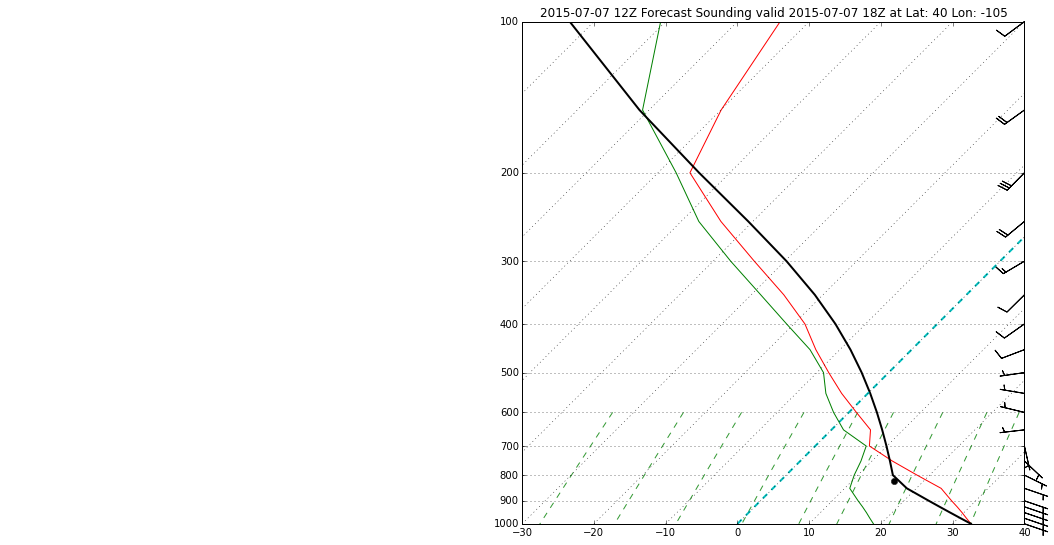

In [7]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)

# Calculate LCL height and plot as black dot
l = lcl(p[0], T[0], Td[0])
lcl_temp = dry_lapse(concatenate((p[0], l)), T[0])[-1].to('degC')
skew.plot(l, lcl_temp, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
l = skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-30,40)
skew.ax.set_title("{} Forecast Sounding valid {} at Lat: {} Lon: {}".format(run_time, valid_time, lat, lon))

In [8]:
stop = dt.datetime.now()
elapsed_time = stop - start
print("This notebook took {:3.1f} seconds to run!".format(elapsed_time.total_seconds()))

This notebook took 8.3 seconds to run!
